In [25]:
import qulacs
from qulacs import QuantumState, QuantumCircuit
from qulacs.state import partial_trace
from qulacs.gate import DenseMatrix
import numpy as np
import numpy.linalg as npl
from scipy.linalg import expm
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
# [0, k): Charlie
# [k, 2k): Alice
# [2k, n+k): Black hole -> [k, n+k)
class YoungBlackHole():
    # dynamicsがheisenbergの時は末尾に一桁の整数をつけると結合定数が指定できる
    # ex) heisenberg123 -> Jx = 1, Jy = 2, Jz = 3
    # いい感じの実装になおしたい気もする
    def __init__(self, n, k, dynamics, depth=-1):
        self.n = n
        self.k = k
        self.size = n + k
        self.dynamics = dynamics
        self.depth=depth
        self.reset()

    def reset(self):
        n, k = self.n, self.k
        dynamics = self.dynamics
        depth = self.depth
        self.state = QuantumState(n + k)
        self.circuit = QuantumCircuit(n + k)
        for i in range(k):
            self.circuit.add_H_gate(i)
            self.circuit.add_CNOT_gate(i, i + k)
        if dynamics == "lrc":
            self.add_LRC(k, n+k, depth)
        elif dynamics == "haar":
            self.circuit.add_random_unitary_gate(list(range(k, n+k)))
        elif dynamics[:10] == "heisenberg":
            self.add_Heisenberg(k, n+k, depth, dynamics[10:])
        else:
            print("invalid dynamics type")

    def update(self):
        self.circuit.update_quantum_state(self.state)

    def add_LRC(self, l, r, depth):
        assert depth>=0 
        for d in range(depth):
            for i in range(l + d % 2, r - 1, 2):
                self.circuit.add_random_unitary_gate([i, i + 1])

    def add_Heisenberg(self, l, r, t, cc):
        size = r-l
        X = np.array([[0, 1],[1, 0]])
        Y = np.array([[0, -1j],[1j, 0]])
        Z = np.array([[1, 0],[0, -1]])
        H = np.zeros((1<<size, 1<<size), dtype='complex128')
        for i in range(l, r-1):
            Jx, Jy, Jz = self.get_coupling_constants(cc)
            print(Jx)
            M = Jx*np.kron(X, X)+Jy*np.kron(Y, Y)+Jz*np.kron(Z, Z)
            if i > k:
                M = np.kron(np.identity(1<<(i-l)), M)
            if i+2 < r:
                M = np.kron(M, np.identity(1<<(r-i-2)))
            H+=M
        U = DenseMatrix(list(range(l, r)), expm(-1j*t*H))
        self.circuit.add_gate(U)

    def get_coupling_constants(self, s):
        if len(s) == 3:
            return list(map(int, list(s)))
        return np.random.random(3)

    # l1 norm
    def L1(self, rad_qubits):
        n, k = self.n, self.k
        l = len(rad_qubits)
        mat_size = pow(2, n+k-l)
        trace = partial_trace(self.state, rad_qubits)
        return npl.norm(trace.get_matrix() - np.identity(mat_size)/mat_size, 'nuc')

    # mutual information
    def MI(self, rad_qubits):
        n, k = self.n, self.k
        l = len(rad_qubits)
        b_qubits = list(filter(lambda x:x not in rad_qubits, range(k, n+k)))
        a_qubits = list(range(k, n + k))
        AB = partial_trace(self.state, b_qubits)
        A = partial_trace(self.state, list(range(k, n + k)))
        B = partial_trace(self.state, a_qubits+b_qubits)
        return self.S(A)+self.S(B)-self.S(AB)

    # coherent information
    def CI(self, rad_qubits):
        n, k = self.n, self.k
        b_qubits = list(filter(lambda x:x not in rad_qubits, range(k, n+k)))
        a_qubits = list(range(k, n + k))
        AB = partial_trace(self.state, b_qubits)
        A = partial_trace(self.state, a_qubits)
        return self.S(A) - self.S(AB)

    # entropy
    def S(self, rho):
        if rho is None:
            return 0
        mat = rho.get_matrix()
        eig_vals = npl.eigvalsh(mat)
        return -(eig_vals * np.log2(eig_vals+0.000001)).sum()

In [108]:
# simulator for young black hole
def simulate(model, l_max, iter_num):
    data_MI = np.zeros((l_max + 1, iter_num))
    data_L1 = np.zeros((l_max + 1, iter_num))
    data_CI = np.zeros((l_max + 1, iter_num))
    for i in range(iter_num):
        rad_qubits = []
        for l in range(l_max + 1):
            if i%10 == 0: print(f"l={l}:{i}-th iteration")
            mat_size = pow(2, n+k-l)
            state = QuantumState(model.size)
            model.update()
            rad_qubits = np.random.randint(k, n+k, l)
            data_L1[l][i] = model.L1(rad_qubits)
            data_MI[l][i] = model.MI(rad_qubits)
            data_CI[l][i] = model.CI(rad_qubits)
            model.reset()
    return data_L1, data_MI, data_CI

# iter_num = 1だとバグるかも
def plot_data(data):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(np.average(data[0], axis=1), label='L1 norm')
    ax.plot(np.average(data[1], axis=1), label='mutual infomation')
    ax.plot(np.average(data[2], axis=1), label='coherent information')
    ax.legend(loc='lower right')
    return fig

def save_data(data, path):
    np.savetxt("data/"+path+"/data_L1.csv", data[0], delimiter=',')
    np.savetxt("data/"+path+"/data_MI.csv", data[1], delimiter=',')
    np.savetxt("data/"+path+"/data_CI.csv", data[2], delimiter=',')

def load_data(path):
    return [np.loadtxt("data/"+path+"/data_L1.csv", delimiter=','),
            np.loadtxt("data/"+path+"/data_MI.csv", delimiter=','),
            np.loadtxt("data/"+path+"/data_CI.csv", delimiter=',')]

l=0:0-th iteration
l=1:0-th iteration
l=2:0-th iteration
l=3:0-th iteration
l=4:0-th iteration
l=5:0-th iteration
l=6:0-th iteration
l=7:0-th iteration
l=8:0-th iteration
l=9:0-th iteration


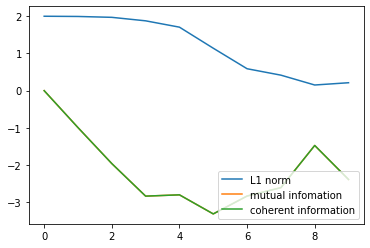

In [109]:
# experiment 1
# haar random unitary
n, k = 9, 1
l_max = 9
iter_num = 2
model = YoungBlackHole(n, k, 'haar')
data = simulate(model, l_max, iter_num)
save_data(data, "experiment1")
fig = plot_data(data)

In [110]:
data

(array([[1.99804687, 1.99804687],
        [1.9921875 , 1.9921875 ],
        [1.96875   , 1.96875   ],
        [1.875     , 1.875     ],
        [1.71037548, 1.69950914],
        [1.16349137, 1.11582871],
        [0.62264424, 0.55433269],
        [0.54903786, 0.28338108],
        [0.17358994, 0.12959061],
        [0.26914626, 0.15613081]]),
 array([[ 0.        ,  0.        ],
        [-0.99207686, -0.99192368],
        [-1.95716648, -1.95895585],
        [-2.82629951, -2.83801791],
        [-2.78017702, -2.81488807],
        [-3.31143618, -3.30838899],
        [-2.82880906, -2.83046823],
        [-3.26354917, -1.94682193],
        [-1.95260211, -0.9910767 ],
        [-2.8175313 , -1.95314276]]),
 array([[ 0.        ,  0.        ],
        [-0.99207686, -0.99192368],
        [-1.95716648, -1.95895585],
        [-2.82629951, -2.83801791],
        [-2.78017702, -2.81488807],
        [-3.31143618, -3.30838899],
        [-2.82880906, -2.83046823],
        [-3.26354917, -1.94682193],
        